In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=11321bafc9646eb00a7388c16978c59e287fe8f931320e395f5c50597e28735e
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


Initial state of qubit 0:


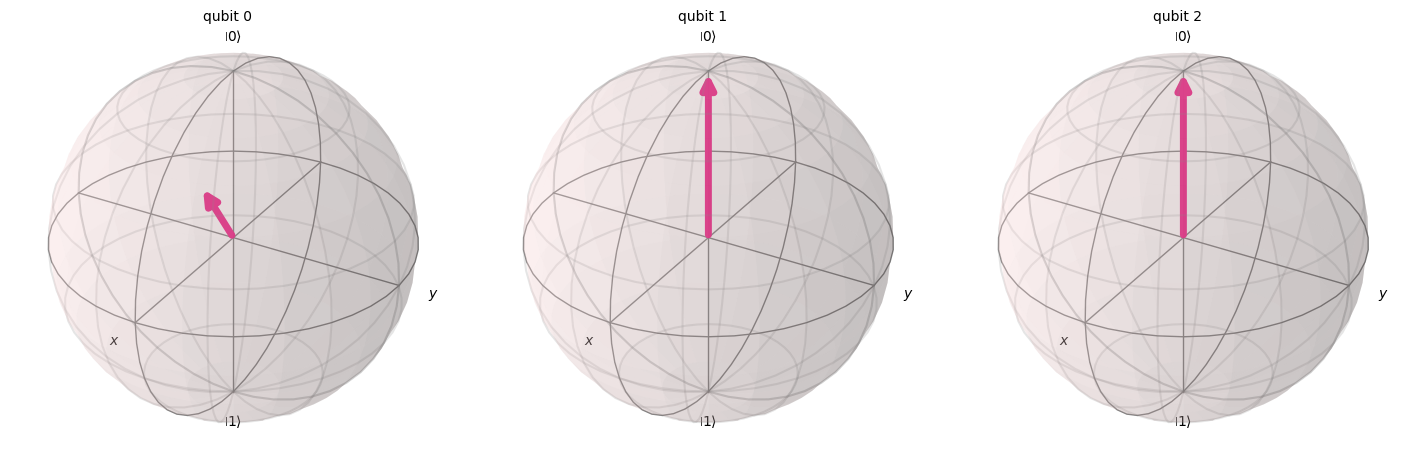

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


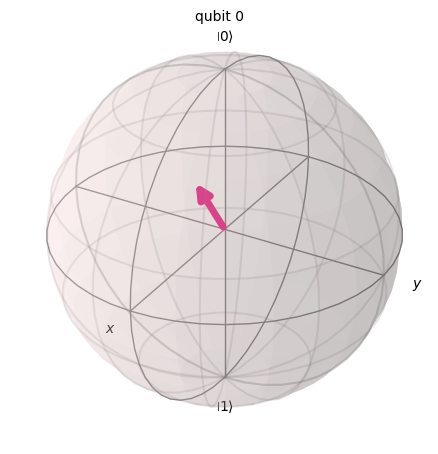

In [2]:
# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))

Task 1

State 1: θ=0.79, φ=0.79


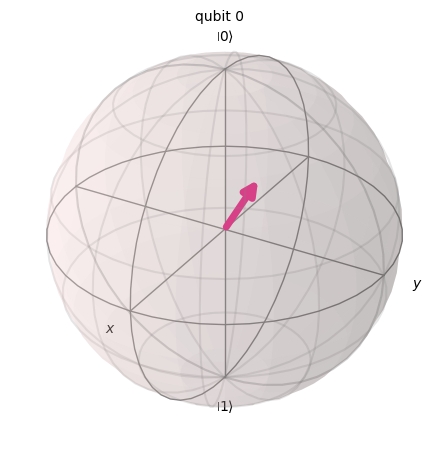

State 2: θ=1.57, φ=1.05


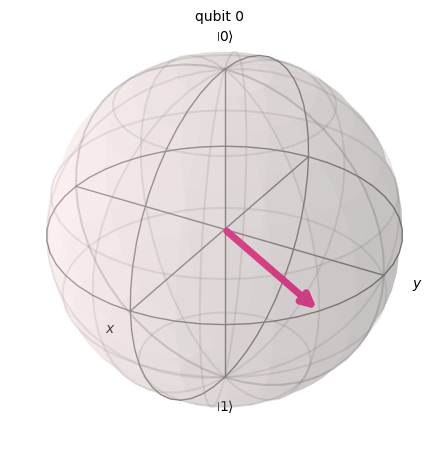

State 3: θ=1.05, φ=0.52


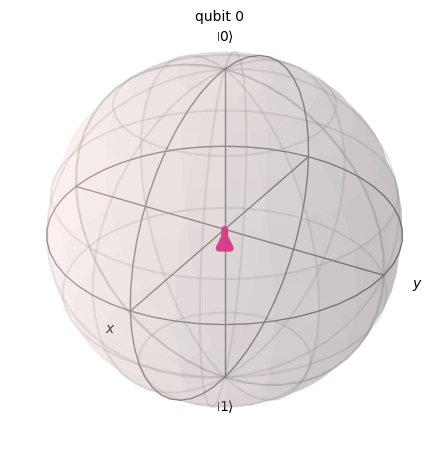

State 4: θ=2.09, φ=0.39


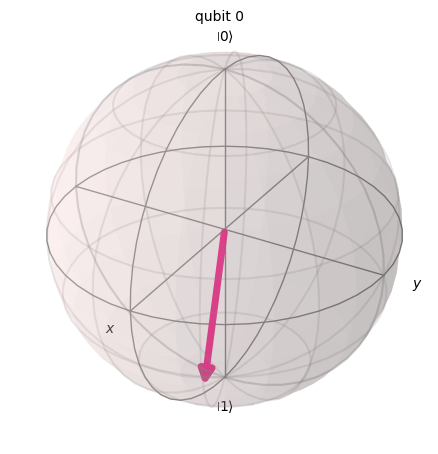

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# Try different (theta, phi) combinations
param_sets = [(np.pi/4, np.pi/4), (np.pi/2, np.pi/3), (np.pi/3, np.pi/6), (np.pi/1.5, np.pi/8)]

for i, (theta, phi) in enumerate(param_sets):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv = Statevector.from_instruction(qc)
    print(f"State {i+1}: θ={theta:.2f}, φ={phi:.2f}")
    display(plot_bloch_multivector(sv))


Task 2

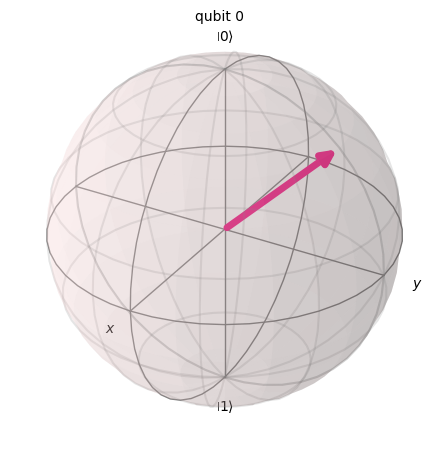

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np

# Create a 3-qubit, 2-classical-bit teleportation circuit
qc = QuantumCircuit(3, 2)

# Step 1: Prepare an arbitrary state |ψ⟩ on qubit 0
theta, phi = np.pi/4, np.pi/2
qc.ry(theta, 0)
qc.rz(phi, 0)

# Step 2: Create a Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Step 3: Bell measurement
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

# Step 4: Apply conditional corrections using `if_test`
# Bob's qubit (qubit 2) should receive corrections depending on both classical bits

with qc.if_test((qc.clbits[1], 1)):  # if bit 1 == 1 → apply X
    qc.x(2)

with qc.if_test((qc.clbits[0], 1)):  # if bit 0 == 1 → apply Z
    qc.z(2)

# Step 5: Save statevector for analysis
qc.save_statevector()

# Step 6: Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Step 7: Extract final statevector
sv_final = Statevector(result.data(0)["statevector"])

# Step 8: Partial trace to get Bob’s final qubit
rho_bob = partial_trace(sv_final, [0, 1])

# Step 9: Visualize Bob’s state on the Bloch sphere
display(plot_bloch_multivector(rho_bob))


Task 3

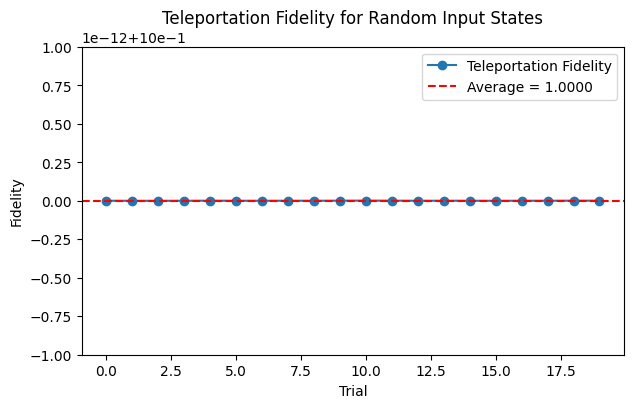

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np
import matplotlib.pyplot as plt

def teleport_fidelity(theta, phi):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_init = Statevector.from_instruction(qc)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)
    qc.save_statevector()

    sim = AerSimulator()
    result = sim.run(transpile(qc, sim)).result()
    sv_final = Statevector(result.data(0)["statevector"])
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_init, [1, 2])

    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]
    return np.abs(np.vdot(init_state, bob_state)) ** 2

# Run for 20 random states
N = 20
thetas = np.random.uniform(0, np.pi, N)
phis = np.random.uniform(0, 2*np.pi, N)
fidelities = [teleport_fidelity(t, p) for t, p in zip(thetas, phis)]

plt.figure(figsize=(7, 4))
plt.plot(fidelities, 'o-', label='Teleportation Fidelity')
plt.axhline(np.mean(fidelities), color='r', linestyle='--', label=f'Average = {np.mean(fidelities):.4f}')
plt.xlabel('Trial')
plt.ylabel('Fidelity')
plt.legend()
plt.title('Teleportation Fidelity for Random Input States')
plt.show()


Task 4

Initial |ψ⟩ on qubit 0


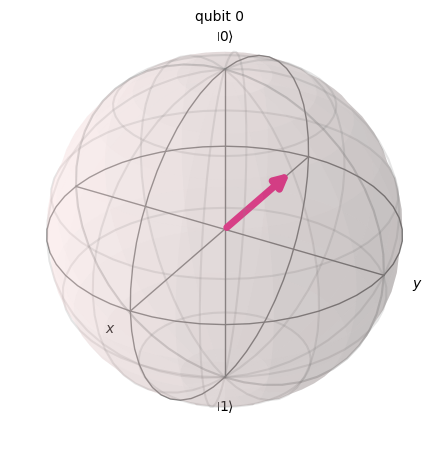

After Bell pair creation


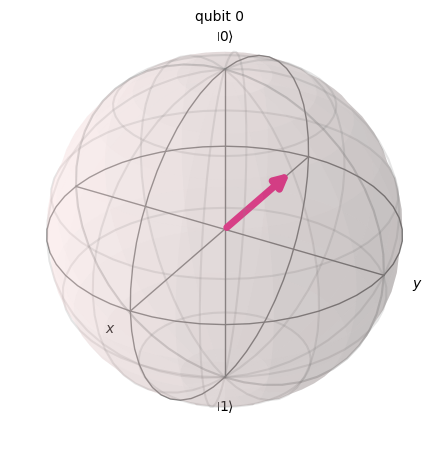

After CX(0,1)


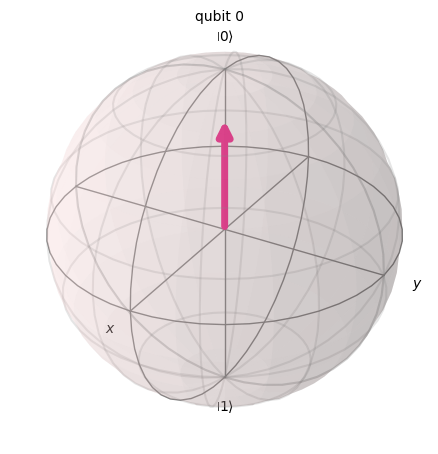

After H on qubit 0


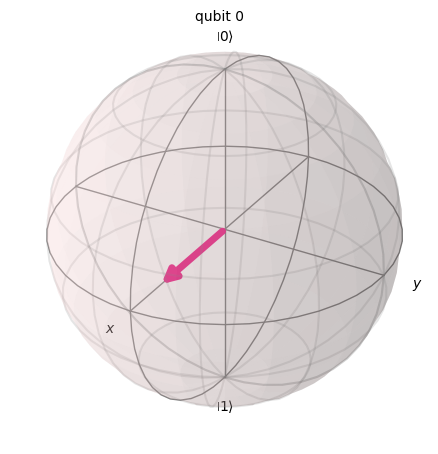

After teleportation complete (Bob’s qubit)


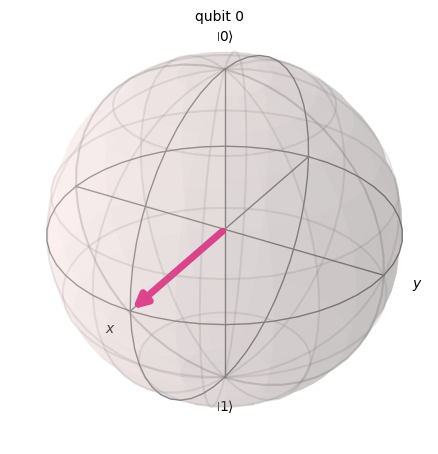

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np

qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/3
qc.ry(theta, 0)
qc.rz(phi, 0)

def show_state(label, qc):
    sv = Statevector.from_instruction(qc)
    rho = partial_trace(sv, [1, 2])  # show qubit 0 by default
    print(label)
    display(plot_bloch_multivector(rho))

show_state("Initial |ψ⟩ on qubit 0", qc)

# Bell pair
qc.h(1)
qc.cx(1, 2)
show_state("After Bell pair creation", qc)

# Entangle and measure steps
qc.cx(0, 1)
show_state("After CX(0,1)", qc)
qc.h(0)
show_state("After H on qubit 0", qc)

# Coherent correction
qc.cx(1, 2)
qc.cz(0, 2)
show_state("After teleportation complete (Bob’s qubit)", qc)


Task 5

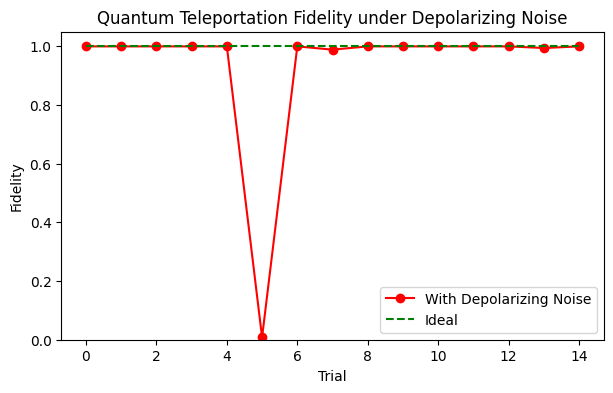

Average noisy fidelity = 0.9328


In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# --- Define a Hermitian-safe noise model (only depolarizing noise) ---
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["ry", "rz", "h"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ["cx", "cz"])

def noisy_fidelity(theta, phi):
    qc = QuantumCircuit(3)

    # 1️⃣ Prepare arbitrary state |ψ⟩
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_init = Statevector.from_instruction(qc)

    # 2️⃣ Create Bell pair
    qc.h(1)
    qc.cx(1, 2)

    # 3️⃣ Bell measurement (coherent form)
    qc.cx(0, 1)
    qc.h(0)

    # 4️⃣ Coherent correction (no measurement → Hermitian)
    qc.cx(1, 2)
    qc.cz(0, 2)

    # 5️⃣ Save final statevector (Hermitian guaranteed)
    qc.save_statevector()

    sim = AerSimulator(noise_model=noise_model)
    result = sim.run(transpile(qc, sim)).result()
    sv_final = Statevector(result.data(0)["statevector"])

    # 6️⃣ Compare Bob’s qubit with original
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_init, [1, 2])

    return state_fidelity(rho_init, rho_bob)


# --- Run over multiple random states ---
N = 15
thetas = np.random.uniform(0, np.pi, N)
phis = np.random.uniform(0, 2*np.pi, N)
f_noisy = [noisy_fidelity(t, p) for t, p in zip(thetas, phis)]
f_ideal = [1.0] * N

# --- Plot ---
plt.figure(figsize=(7, 4))
plt.plot(f_noisy, "ro-", label="With Depolarizing Noise")
plt.plot(f_ideal, "g--", label="Ideal")
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Quantum Teleportation Fidelity under Depolarizing Noise")
plt.legend()
plt.ylim([0, 1.05])
plt.show()

print(f"Average noisy fidelity = {np.mean(f_noisy):.4f}")
